In [1]:
import warnings; warnings.simplefilter('ignore') # this line is to ignore the warnings.
import pandas as pd
import numpy as np

companies=pd.read_csv('companies.txt',sep='\t',encoding='ISO-8859-1')
rounds2=pd.read_csv('rounds2.csv',encoding='ISO-8859-1')
print(companies.shape)
print(rounds2.shape)

(66368, 10)
(114949, 6)


In [2]:
#checking the unique permalink persent in companies table.
#this number will be equal to the number of unique comapny present in companies data set.
companies['permalink']=companies['permalink'].apply(lambda x:x.lower().encode('ISO-8859-1','ignore').decode('ascii','ignore'))
print("The number of unique company in Companies dataset :",companies['permalink'].nunique())

The number of unique company in Companies dataset : 66368


In [3]:
#checking the unique permalink persent in round2 table.
#this number will be equal to the number of unique comapny present in rounds2 data set.
rounds2['company_permalink']=rounds2['company_permalink'].apply(lambda x:x.lower().encode('ISO-8859-1','ignore').decode('ascii','ignore'))
print("The number of unique company in round2 dataset :",rounds2['company_permalink'].nunique())

The number of unique company in round2 dataset : 66368


In [4]:
#this code will  tell us the unique companies present in round2 but not in companies data set
companiesuniquevalue=set(companies['permalink'].unique().tolist())
round2uniquevaluelue=set(rounds2['company_permalink'].unique().tolist())
print("Number of Unique companies present in rounds2 data set and not present in companies dataset :",len(round2uniquevaluelue-companiesuniquevalue))

Number of Unique companies present in rounds2 data set and not present in companies dataset : 0


In [5]:
#merging the two data set round2 and company
master_frame=pd.merge(rounds2,companies,left_on='company_permalink',right_on='permalink',how='inner')
print("Number of observation in master data frame:",master_frame.shape)

Number of observation in master data frame: (114949, 16)


In [6]:
#code to calculate the most representational value for each fund type
avgvalue=master_frame.groupby('funding_round_type').raised_amount_usd.mean()
print("Average funding for angel type :",avgvalue.loc['angel'])
print("Average funding for seed type :",avgvalue.loc['seed'])
print("Average funding for venture type :",avgvalue.loc['venture'])
print("Average funding for private_equity type :",avgvalue.loc['private_equity'])

Average funding for angel type : 958694.4697530865
Average funding for seed type : 719817.9969071728
Average funding for venture type : 11748949.129489528
Average funding for private_equity type : 73308593.02944215


In [7]:
#creating a venturedataframe which will have data whose funding type is venture
venturedataframe=master_frame.loc[master_frame.funding_round_type.str.lower()=='venture']
print("Total number of data with venture type funding is :",venturedataframe.shape[0])

Total number of data with venture type funding is : 55494


In [8]:
#top9 country which got highest funding type
top9=pd.DataFrame(venturedataframe.groupby('country_code').raised_amount_usd.sum().sort_values(ascending=False))[0:9]
top9

,raised_amount_usd
country_code,
USA,4.225108e+11
CHN,3.983542e+10
GBR,2.024563e+10
IND,1.439186e+10
CAN,9.583332e+09
FRA,7.259537e+09
ISR,6.907515e+09
DEU,6.346960e+09
JPN,3.363677e+09


In [9]:
#create the ctgdataframe which will contain the column primary sector 
ctgdataframe=venturedataframe.loc[venturedataframe.category_list.notnull()]
ctgdataframe.loc[:,'primary_sector']=ctgdataframe.loc[:,'category_list'].apply(lambda x:x.split("|")[0].lower())

#reading the mapping file and mapping each category with the corresponding major sector
mappingdf=pd.read_csv("mapping.csv")
mappingdf=mappingdf.loc[mappingdf.category_list.notnull()]
mappingdf.loc[:,'category_list']=mappingdf.loc[:,'category_list'].apply(lambda x:x.replace('0','na').replace('.na','.0').lower())
melteddf = pd.melt(mappingdf,id_vars=["category_list"],var_name="major_sector", value_name="Value")
primary_sector_mapping=melteddf[melteddf.Value==1]

#Code for a merged data frame with each primary sector mapped to its main sector 
major_sector_df=pd.merge(ctgdataframe,primary_sector_mapping,left_on="primary_sector",right_on="category_list",how="inner")
major_sector_df.drop(["category_list_y","Value"],axis=1,inplace=True)
major_sector_df.rename(columns={'category_list_x': 'category_list'}, inplace=True)

#displaying info of resultant data frame
major_sector_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 54348 entries, 0 to 54347
Data columns (total 18 columns):
company_permalink          54348 non-null object
funding_round_permalink    54348 non-null object
funding_round_type         54348 non-null object
funding_round_code         30500 non-null object
funded_at                  54348 non-null object
raised_amount_usd          49712 non-null float64
permalink                  54348 non-null object
name                       54348 non-null object
homepage_url               51734 non-null object
category_list              54348 non-null object
status                     54348 non-null object
country_code               52011 non-null object
state_code                 51113 non-null object
region                     51341 non-null object
city                       51341 non-null object
founded_at                 43972 non-null object
primary_sector             54348 non-null object
major_sector               54348 non-null object
dtypes: 

In [10]:
#creating three data frames D1, D2 and D3 for each of the three countries(USA,GBR,IND) containing 
#the observations of funding type FT falling within the 5-15 million USD range

D1=major_sector_df.loc[(major_sector_df.country_code == 'USA') & (major_sector_df.raised_amount_usd >= 5000000) & (major_sector_df.raised_amount_usd <= 15000000)]
D2=major_sector_df.loc[(major_sector_df.country_code == 'GBR') & (major_sector_df.raised_amount_usd >= 5000000) & (major_sector_df.raised_amount_usd <= 15000000)]
D3=major_sector_df.loc[(major_sector_df.country_code == 'IND') & (major_sector_df.raised_amount_usd >= 5000000) & (major_sector_df.raised_amount_usd <= 15000000)]

#applying the group by function to get the count and sum of each major sector investment
Count_sum_df_D1=D1.groupby("major_sector").raised_amount_usd.agg({'count':'count','sum':'sum'})
Count_sum_df_D2=D2.groupby("major_sector").raised_amount_usd.agg({'count':'count','sum':'sum'})
Count_sum_df_D3=D3.groupby("major_sector").raised_amount_usd.agg({'count':'count','sum':'sum'})

#code to merge the group by result with each country data frame.So that it will contain two sperate list of sum and count column
D1=pd.merge(D1,Count_sum_df_D1,on="major_sector",how="inner")
D2=pd.merge(D2,Count_sum_df_D2,on="major_sector",how="inner")
D3=pd.merge(D3,Count_sum_df_D1,on="major_sector",how="inner")

#Displaying the info of all three data frame
D1.info()
D2.info()
D3.info()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 12063 entries, 0 to 12062
Data columns (total 20 columns):
company_permalink          12063 non-null object
funding_round_permalink    12063 non-null object
funding_round_type         12063 non-null object
funding_round_code         8618 non-null object
funded_at                  12063 non-null object
raised_amount_usd          12063 non-null float64
permalink                  12063 non-null object
name                       12063 non-null object
homepage_url               11495 non-null object
category_list              12063 non-null object
status                     12063 non-null object
country_code               12063 non-null object
state_code                 12061 non-null object
region                     12054 non-null object
city                       12054 non-null object
founded_at                 10390 non-null object
primary_sector             12063 non-null object
major_sector               12063 non-null object
count    

In [11]:
#code to capture the table details for country C1(USA)

print("Total number of investments (count):",D1['raised_amount_usd'].count())
print("Total amount of investment (USD):",D1['raised_amount_usd'].sum())

#code to get Top sectors (based on count of investments)
sector_details=D1.groupby("major_sector").funding_round_permalink.count().sort_values(ascending=False)
print("Sector details for the C1 country")
print(sector_details)

#code to get the company detail which received the highest investment for the top sector and second top sector
D1[D1.major_sector=='Others'].groupby(["company_permalink","name"]).raised_amount_usd.sum().sort_values(ascending=False)
D1[D1.major_sector=='Social, Finance, Analytics, Advertising'].groupby(["company_permalink","name"]).raised_amount_usd.sum().sort_values(ascending=False)


Total number of investments (count): 12063
Total amount of investment (USD): 107757097294.0
Sector details for the C1 country
major_sector
Others                                     2950
Social, Finance, Analytics, Advertising    2714
Cleantech / Semiconductors                 2350
News, Search and Messaging                 1583
Health                                      909
Manufacturing                               799
Entertainment                               591
Automotive & Sports                         167
Name: funding_round_permalink, dtype: int64


company_permalink                        name                           
/organization/shotspotter                SST Inc. (Formerly ShotSpotter)    67933006.0
/organization/demandbase                 Demandbase                         63000000.0
/organization/intacct                    Intacct                            61800000.0
/organization/netbase                    NetBase Solutions                  60600000.0
/organization/lotame                     Lotame                             59700000.0
/organization/firstrain                  FirstRain                          58344731.0
/organization/choicestream               ChoiceStream                       58300000.0
/organization/optier                     OpTier                             55600000.0
/organization/damballa                   Damballa                           55000000.0
/organization/zoove                      Zoove                              54800000.0
/organization/xactly-corp                Xactly Corp     

In [12]:
#code to capture the table details for country C2(GBR)

print("Total number of investments (count):",D2['raised_amount_usd'].count())
print("Total amount of investment (USD):",D2['raised_amount_usd'].sum())

#code to get Top sectors (based on count of investments)
sector_details=D2.groupby("major_sector").funding_round_permalink.count().sort_values(ascending=False)
print("Sector details for the C1 country")
print(sector_details)

#code to get the company detailse which received the highest investment for the top sector and 2 top sector
D2[D2.major_sector=='Others'].groupby(["company_permalink","name"]).raised_amount_usd.sum().sort_values(ascending=False)
D2[D2.major_sector=='Social, Finance, Analytics, Advertising'].groupby(["company_permalink","name"]).raised_amount_usd.sum().sort_values(ascending=False)


Total number of investments (count): 621
Total amount of investment (USD): 5379078691.0
Sector details for the C1 country
major_sector
Others                                     147
Social, Finance, Analytics, Advertising    133
Cleantech / Semiconductors                 130
News, Search and Messaging                  73
Entertainment                               56
Manufacturing                               42
Health                                      24
Automotive & Sports                         16
Name: funding_round_permalink, dtype: int64


company_permalink                                   name                                
/organization/celltick-technologies                 Celltick Technologies                   37500000.0
/organization/mythings                              myThings                                34000000.0
/organization/zopa                                  Zopa                                    32900000.0
/organization/imagini                               VisualDNA                               28550000.0
/organization/marketinvoice                         MarketInvoice                           25553007.0
/organization/sumup                                 SumUp                                   24293649.0
/organization/amplience                             Amplience                               24200000.0
/organization/garlik                                Garlik                                  22350000.0
/organization/sportpursuit                          SportPursuit                       

In [13]:
#code to capture the table details for country C3(IND)

print("Total number of investments (count):",D3['raised_amount_usd'].count())
print("Total amount of investment (USD):",D3['raised_amount_usd'].sum())

#code to get Top sectors (based on count of investments)
sector_details=D3.groupby("major_sector").funding_round_permalink.count().sort_values(ascending=False)
print("Sector details for the C1 country")
print(sector_details)

#code to get the company detailse which received the highest investment for the top sector and 2 top sector
D3[D3.major_sector=='Others'].groupby(["company_permalink","name"]).raised_amount_usd.sum().sort_values(ascending=False)
D3[D3.major_sector=='Social, Finance, Analytics, Advertising'].groupby(["company_permalink","name"]).raised_amount_usd.sum().sort_values(ascending=False)


Total number of investments (count): 328
Total amount of investment (USD): 2949543602.0
Sector details for the C1 country
major_sector
Others                                     110
Social, Finance, Analytics, Advertising     60
News, Search and Messaging                  52
Entertainment                               33
Manufacturing                               21
Cleantech / Semiconductors                  20
Health                                      19
Automotive & Sports                         13
Name: funding_round_permalink, dtype: int64


company_permalink                                           name                                          
/organization/manthan-systems                               Manthan Systems                                   50700000.0
/organization/komli-media                                   Komli Media                                       28000000.0
/organization/shopclues-com                                 ShopClues.com                                     25000000.0
/organization/intarvo                                       inTarvo                                           21900000.0
/organization/grameen-financial-services                    Grameen Financial Services                        21556050.0
/organization/bankbazaar                                    BankBazaar.com                                    19000000.0
/organization/microland                                     Microland                                         18300000.0
/organization/eka-software-solutions          

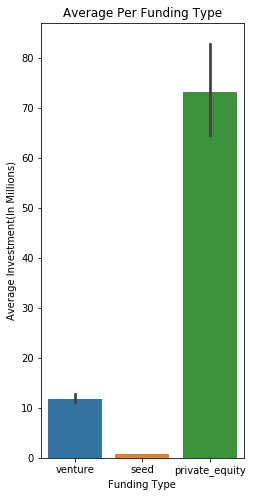

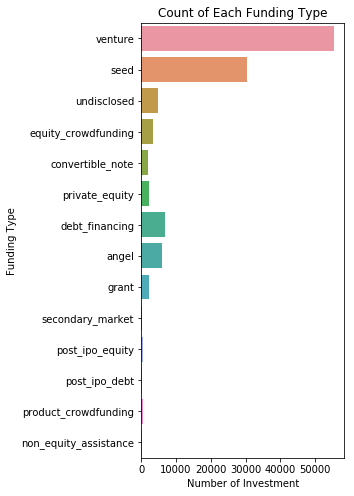

In [14]:
#code to plot the graph for showing the avg funding in venture,seed and private equity funding type
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
fundingtypedf=master_frame.loc[(master_frame.funding_round_type=='venture') | (master_frame.funding_round_type=='seed') | (master_frame.funding_round_type=='private_equity')]
plt.figure(1,figsize=(8, 8))
plt.subplot(121)
sns.barplot(x='funding_round_type', y=fundingtypedf['raised_amount_usd']/1000000, data=fundingtypedf)
plt.ylabel('Average Investment(In Millions)')
plt.xlabel('Funding Type')
plt.title("Average Per Funding Type")

plt.figure(2,figsize=(8, 8))
plt.subplot(122)
sns.countplot(y='funding_round_type',data=master_frame)
plt.ylabel('Funding Type')
plt.xlabel('Number of Investment')
plt.title("Count of Each Funding Type")

plt.show()

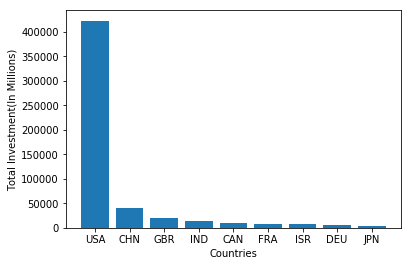

In [15]:
#code to plot the graph for the top 9 countries

plt.bar(top9.index,top9['raised_amount_usd']/1000000)
plt.xlabel("Countries")
plt.ylabel("Total Investment(In Millions)")
plt.show()

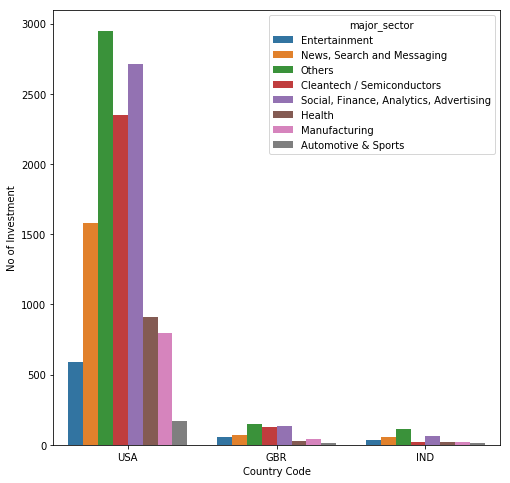

In [16]:
#code to plot the graph for the major sector for top3 english speaking country

resultant=pd.concat([D1,D2,D3])
plt.figure(figsize=(8, 8))
sns.countplot(x='country_code',hue='major_sector',data=resultant)
plt.xlabel("Country Code")
plt.ylabel("No of Investment")
plt.show()